In [26]:
# Import all package dependencies
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from google.colab import drive
import shutil

In [3]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [2]:
# Read datasets
df = pd.read_csv('gold_price_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


In [3]:
df.sample(5)

,Date,Value
6502,2003-10-13,370.25
2408,1988-02-02,455.90
2051,1986-09-19,430.00
1945,1986-04-24,344.75
3620,1992-09-24,348.25


Text(0.5, 1.0, 'Gold price')

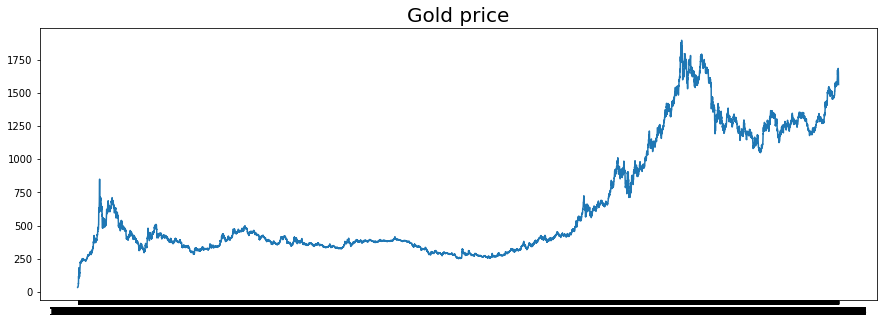

In [4]:
# Plot dataset to see the pattern
dates = df['Date'].values
value = df['Value'].values

plt.figure(figsize=(15, 5))
plt.plot(dates, value)
plt.title('Gold price',
         fontsize=20)

In [5]:
# Split train and validation set 80:20
df_train = df['Value'][:8630].values.reshape(-1,1)
df_test = df['Value'][8630:].values.reshape(-1,1)

print("df_train", df_train.shape)
print("df_test", df_test.shape)

df_train (8630, 1)
df_test (2157, 1)


In [6]:
# See data sample before normalize
print(df_train[0])
print(df_test[0])

[35.2]
[1715.]


In [7]:
# Normalize dataset with MinMaxScaler
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train).ravel()

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test).ravel()

In [8]:
# See sample after normalize
print(scaled_train.shape)
print(scaled_test[0])

(8630,)
0.8966121101906106


In [9]:
# Function below accept argument of series/attribute and convert it to numpy and return attribute and label
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
# Create windowed dataset
train_set = windowed_dataset(scaled_train, window_size=60, batch_size=128, shuffle_buffer=1000)
test_set = windowed_dataset(scaled_test, window_size=60, batch_size=128, shuffle_buffer=1000)
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [11]:
# Initiate LSTM Model
def build_model(hp):
  model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  return model

In [12]:
# Initiate callback function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.1 and logs.get('val_mae') < 0.1):
      print("\nMAE score is already lesser than 10% data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [17]:
# Use keras tuner to find best model
tuner = kt.RandomSearch(build_model, objective='val_mae', max_trials=20, executions_per_trial=2, directory='/content/tuner')

In [18]:
tuner.search(train_set, epochs=150, validation_data=test_set,
             callbacks=[callbacks], batch_size=256)

Trial 1 Complete [01h 24m 37s]
val_mae: 0.11272843927145004

Best val_mae So Far: 0.11272843927145004
Total elapsed time: 01h 24m 37s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in /content/tuner/untitled_project
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
default configuration
Score: 0.11272843927145004


In [20]:
# Save best model as training model
best_model = tuner.get_best_models(num_models=1)[0]

In [24]:
hist = best_model.fit(train_set, epochs=100, 
              validation_data=test_set, callbacks=[callbacks])

Epoch 1/100
     67/Unknown - 12s 174ms/step - loss: 0.0042 - mae: 0.0539
MAE score is already lesser than 10% data scale
67/67 [==============================] - 14s 195ms/step - loss: 0.0042 - mae: 0.0539 - val_loss: 0.0101 - val_mae: 0.0988


In [27]:
# Save Model to Google Drive

# Mount google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
# Save model to /content
best_model.save('gold_price_forecasting_model.h5')

In [29]:
# Save model to desired drive destination
shutil.copy('/content/gold_price_forecasting_model.h5','/content/gdrive/MyDrive/ml_model/')

'/content/gdrive/MyDrive/ml_model/gold_price_forecasting_model.h5'

In [30]:
# Try to load model
load_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ml_model/bbc_classification_model.h5')
load_model

In [22]:
# Create function to plot training graph:
def plot_graph(history, history2, title, xlabel, ylabel):
  plt.plot(hist.history[history])
  plt.plot(hist.history[history2])
  plt.title(title)
  plt.ylabel(xlabel)
  plt.xlabel(ylabel)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

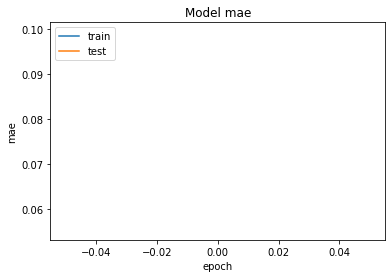

In [23]:
# Plot mae
plot_graph('mae', 'val_mae', 'Model mae', 'mae', 'epoch')

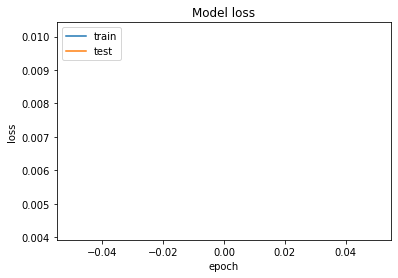

In [25]:
# Plot loss
plot_graph('loss', 'val_loss', 'Model loss', 'loss', 'epoch')